# **Extract roads from satellite images**
# CS-433
This folder consists of implementation for project 2 of [**EPFL CS-433**](https://edu.epfl.ch/coursebook/en/machine-learning-CS-433) course.

# Introduction
Here you can find all the code for [**Class Project 2 | Road Segmentation**](https://www.aicrowd.com/challenges/epfl-ml-road-segmentation) competition (2022). The goal of the project was to create road segmentation algorithm for satellite images. For the best performance of the task we used U-net neural network model and implement data augmentation process, some losses to train with.
For this problem, used a set of satellite images acquired from GoogleMaps where each pixel is labeled as {road, background}. Our goal is to train a classifier to segment roads in these images, i.e. assign a label {road=1, background=0} to each pixel.

##1. **Upload important libraries**

In [ ]:
# libraries
import ast
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from PIL import Image
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Concatenate, MaxPool2D, Dropout, LeakyReLU

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


2022-12-20 20:11:09.018564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. **Upload data**
For data upload: follow the link : https://www.aicrowd.com/challenges/epfl-ml-road-segmentation/dataset_files. Before running the code make sure that you download train and test datasets to the directory ```data/```. You should have such folder structure:
```
data/
  test_set_images/
  training/
    groundtruth/
    images/
```

In [ ]:
# for manually uploading remove quotes

FILE_PATH = "./data" 
TRAIN_FEATURES_PATH = FILE_PATH + '/training/images'
TRAIN_LABELS_PATH = FILE_PATH + '/training/groundtruth'
TEST_FEATURES_PATH = FILE_PATH + '/test_set_images'


Or use google drive with already uploaded data in the corresponding folders and put it on your google drive in MyDrive section: https://drive.google.com/drive/folders/1sETvpSVuvLm1zewQdSBcWdmoLIns5NTB?usp=share_link

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir("/content/drive/MyDrive/data")

# os.getcwd() # check dir

In [ ]:
# paths for data upload
# FILE_PATH = "/content/drive/MyDrive/" 
# TRAIN_FEATURES_PATH = FILE_PATH + '/data/training/images'
# TRAIN_LABELS_PATH = FILE_PATH + '/data/training/groundtruth'
# TEST_FEATURES_PATH = FILE_PATH + '/data/test_set_images'

## 2.1 Implementation of useful functions for loading train with labels and test data.

In [ ]:
# parameters for data
TRAIN_SAMPLES = 100
TEST_SAMPLES = 50
VAL_RATIO = 0.2
USE_SHUFFLE = False 

In [ ]:
# loading train data with labels
def load_train_data():
    x_train = []
    y_train = []
    for i in range(TRAIN_SAMPLES):
        img_name = '/satImage_{:03}.png'.format(i+1)
        train_feature = plt.imread(TRAIN_FEATURES_PATH + img_name)
        train_label = plt.imread(TRAIN_LABELS_PATH + img_name)
        x_train.append(train_feature)
        y_train.append(train_label)
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    return x_train, y_train
# transfrom labels
def transform_labels(y_train):
    y_train = np.round(y_train)
    y_train = y_train[..., np.newaxis]
    return y_train

In [ ]:
# splitting data to train and validation sets
def train_test_split(x, y, validation_ratio=VAL_RATIO, shuffle=USE_SHUFFLE):
    train_num = int(np.round(x.shape[0] * (1 - validation_ratio)))
    if shuffle:
        indexes = np.random.permutation(np.arange(x.shape[0]))
        x = x[indexes]
        y = y[indexes]
    x_test = x[train_num:,:,:,:]
    y_test = y[train_num:,...]
    x_train = x[:train_num,...]
    y_train = y[:train_num,...]
    return x_train, y_train, x_test, y_test

In [ ]:
# loading test data
def load_test_data():
    data = []
    for i in range(TEST_SAMPLES):
        img_name = '/test_{}/test_{}.png'.format(i+1, i+1)
        test_feature = plt.imread(TEST_FEATURES_PATH + img_name)
        data.append(test_feature)
    data = np.asarray(data)
    return data

In [ ]:
def save_preds(preds):
    path = '/data/predictions'
    for i in range(len(preds)):
        img = Image.fromarray((preds[i,:,:,0] * 255.).astype(np.uint8))
        full_name = FILE_PATH + path + f'/pred_{i+1}.png'
        img.save(full_name)

## 3. **Implementation of models architecture**
U-Net is a convolutional neural network that was developed initially for biomedical image segmentation. Implementation the U-Net architecture for performing an image segmentation task. Since we are doing image segmentation, we choose to use a U-Net architecture here, which was first introduced in the paper "U-Net: Convolutional Networks for Biomedical Image Segmentation" ([link to paper](https://arxiv.org/abs/1505.04597) for the interested). The original architecture looks like this:



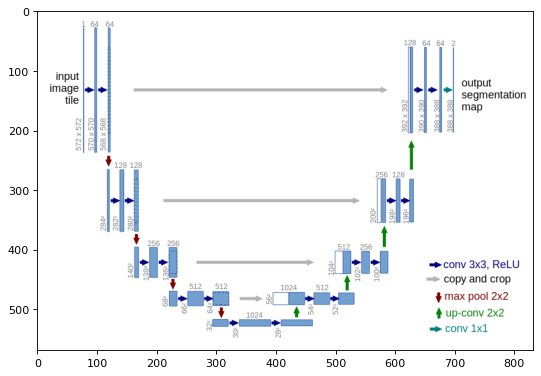

In [ ]:
# Read Images of U-NET architecture
img = mpimg.imread(FILE_PATH + "/unet.png")
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(img);

We will quote the architecture description from the paper directly: 

> It consists of a contracting path (left side) and an expansive path (right side). 

> The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of **two 3x3 convolutions** (unpadded convolutions), each followed by a **rectified linear unit (ReLU)** and a **2x2 max pooling operation with stride 2** for downsampling. At each downsampling step we double the number of feature channels. 


> Every step in the expansive path consists of an **upsampling** of the feature map followed by a **2x2 convolution (“up-convolution”)** that halves the number of feature channels, a **concatenation with the correspondingly cropped feature map** from the contracting path, and **two 3x3 convolutions**, each followed by a **ReLU**. The cropping is necessary due to the loss of border pixels in every convolution. At the final layer a 1x1 convolution is used to map each 64- component feature vector to the desired number of classes. In total the network has 23 convolutional layers.

Constructs U-Net model with the given parameters :


  - ```input_side```: size of the image for the input to the model
  - ```activation```: activation which is used in conv layers
  - ```regularizer_```: regularizer which used in Conv layers
  - ```starting_num_channels```: number of channels in the input
  - ```optimizer```: optimizer to update weights
  - ```loss```: loss function to minimize
  - ```metrics```: metrics to track during the training
  - ```num_blocks```: number of blocks in both encoder and decorder part

In [ ]:
INPUT_SIDE = 128

In [ ]:
def Unet(params):
    num_blocks = params['num_blocks']
    input_side = params['input_side']
    activation_ = params['activation_']
    regularizer_ = params['regularizer_']
    starting_num_channels = params['starting_num_channels']
    optimizer = params['optimizer']
    loss = params['loss']
    metrics = params['metrics']
    dropout = params['dropout']

    tensors = {}
    tensors['inputs'] = Input(shape=(input_side, input_side, 3), name='input')

    for encoder_block in range(num_blocks):
        
        last_output = None
        dropout_rate = dropout
        if encoder_block == 0:
            last_output = 'inputs'
        else:
            last_output = f'pool_{encoder_block-1}'
        conv_cur = f'conv2d_{encoder_block}'
        channels = starting_num_channels * (2**(encoder_block))

        tensors[conv_cur] = Conv2D(channels, (3,3), strides = (1,1), padding='same', activation=activation_, 
                                   kernel_regularizer=regularizer_, name=f'conv2d_{2*encoder_block}')(tensors[last_output])
        tensors[conv_cur] = BatchNormalization()(tensors[conv_cur])
        tensors[conv_cur] = Dropout(dropout_rate)(tensors[conv_cur])
        tensors[conv_cur] = Conv2D(channels, (3,3), strides = (1,1), padding='same', activation=activation_, kernel_regularizer=regularizer_, 
                                   name=f'conv2d_{2*encoder_block+1}')(tensors[conv_cur])
        tensors[conv_cur] = BatchNormalization()(tensors[conv_cur])
        if encoder_block+1 != num_blocks:
            pool_cur = f'pool_{encoder_block}'
            tensors[pool_cur] = MaxPool2D((2, 2), strides=(2,2))(tensors[conv_cur])
        
    for decoder_block in range(num_blocks-1):

        last_output = f'conv2d_{num_blocks+decoder_block-1}'
        dropout_rate = dropout
        conv_cur = f'conv2d_{num_blocks+decoder_block}'
        conv_to_concat = f'conv2d_{num_blocks-decoder_block-2}'
        channels = starting_num_channels * (2**(num_blocks-decoder_block-2))
        num_conv2d_blocks = 2*(num_blocks+decoder_block)
        
        tensors[conv_cur] = Conv2DTranspose(channels, (3,3), strides=(2,2), padding='same', activation='linear', 
                                            kernel_regularizer=regularizer_, name=f'conv2d_transpose_{decoder_block}')(tensors[last_output])
        tensors[conv_cur] = Concatenate(axis=-1)([tensors[conv_cur], tensors[conv_to_concat]])
        tensors[conv_cur] = Conv2D(channels, (3,3), padding='same', activation=activation_, 
                                   kernel_regularizer=regularizer_, name=f'conv2d_{num_conv2d_blocks}')(tensors[conv_cur])
        tensors[conv_cur] = BatchNormalization()(tensors[conv_cur])
        tensors[conv_cur] = Dropout(dropout_rate)(tensors[conv_cur])
        tensors[conv_cur] = Conv2D(channels, (3,3), padding='same', activation=activation_, kernel_regularizer=regularizer_, 
                                   name=f'conv2d_{num_conv2d_blocks+1}')(tensors[conv_cur])
        tensors[conv_cur] = BatchNormalization()(tensors[conv_cur])
    #last ecoder block
    last_output = f'conv2d_{2*num_blocks-2}'
    tensors['outputs'] = Conv2D(1, (3,3), padding='same', activation='sigmoid', name='conv2d_last')(tensors[last_output])

    model = Model(inputs=tensors['inputs'], outputs=tensors['outputs'])
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


## 4. **Implementations of losses for training the model**
We use a weighted binary cross entropy loss and soft dice loss for our loss, since image segmentation is actually a classification problem (you can think of it as classifying what object the pixels belong to, if they belong to any.) Dice loss is a measure of overlap between the prediction and the ground truth labels and is also used for image segmentation tasks.

In [ ]:
def soft_dice_loss(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union_approx = K.sum(y_true_f) + K.sum(y_pred_f)
    inters_oer_union_approx = (2 * intersection + smooth) / (union_approx + smooth)
    return 1 -  inters_oer_union_approx


def weighted_binary_crossentropy(y_true, y_pred, weight=4):
    '''
    weight: int
        weight to be set to road labels while retaining 1 weight for non-road labels
    '''
    weights = y_true * (weight-1) + 1
    weighted_bce = K.binary_crossentropy(y_true, y_pred) * weights
    return K.mean(weighted_bce)


def total_variation(image, norm='l2'):
    x_diff = K.abs(image[:,1:,:,:] - image[:,:-1,:,:])
    y_diff = K.abs(image[:,:,1:,:] - image[:,:,:-1,:])
    res = None
    if norm == 'l1':
        res = K.mean(x_diff)+K.mean(y_diff)
    elif norm == 'l2':
        res = K.sqrt(K.mean(K.square(x_diff))) + K.sqrt(K.mean(K.square(x_diff)))
    else:
        raise Exception('Invalid norm value')
    return res


class SoftDiceLossRegularized():
    
    def __init__(self, lambd = 1e-2, smooth = 1, norm='l2'):
        
        self.lambd = lambd
        self.smooth = smooth
        self.norm = norm
    
    def soft_dice_loss_regularized(self, y_true, y_pred):
        
        return soft_dice_loss(y_true, y_pred, self.smooth) + \
            self.lambd * total_variation(y_pred, self.norm)


class WeightedBCERegularized():

    def __init__(self, lambd = 1e-2, weight = 4, norm='l2'):
        
        self.lambd = lambd
        self.weight = weight
        self.norm = norm
    
    def weighted_bce_regularized(self, y_true, y_pred):
        
        return weighted_binary_crossentropy(y_true, y_pred, self.weight) + \
            self.lambd * total_variation(y_pred, self.norm)

## 5. **Implementations of metrics for training the model**
Using F1-score for  the training model performance

In [ ]:
def F1_score(y_true, y_pred, delta=1e-8):
    y_pred = K.round(y_pred)
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    precision = TP / (TP + FP + delta)
    recall = TP / (TP + FN + delta)
    f1_score = 2 * precision * recall / (precision + recall + delta) 
    return f1_score


## 6. **The class for wrapping the model**
The class for wrapping the model constructed before(look at the section  3. Implementation model U-Net), so we can perform training, evaluation, prediction, saving and loading the model:
 ```Parameters``` is dictionary with the next keys: 
  - ```input_side```: size of the side of the images to feed to the network
  - ```image_side```: size of the initial image
  - ```reg_name```: None or str from ['l1', 'l2'] name of regularizer. It is used only to track the regularization penalty of the model
  - ```lambd```: regularization parameter
  - ```batch_size```: batch size
  - ```path```: path to save and load the model
  - ```main_metric_fn```: function which used for metric
  - ```main_metric_name```: string which names this metric

  - ```shift```: could be None or int. Specifies how we slide the window when predicting the full_size image

In [ ]:
class ModelWrapper():
    #initialize an instance of ModelWrapper to perform training, evaluation and prediction with given parameters. 
    def __init__(self, model, params):
        '''

        Parameters
        ----------
        model : tf.keras.Model
        params : dict
            Must contain the following attributes:
                params['metrics_names']: list
                    names of metrics tracked by model
                params['input_side']: int
                    model's input must have (input_side, input_side, 3) shape
                params['image_side']: int
                    side of images to be received for training
                params['reg_name']: None or str from ['l1', 'l2']
                    name of regularizer. It is used only to track the regularization
                    penalty of the model
                params['lambd']: float
                    regularization parameter
                params['batch_size']: int
                params['batches_per_epoch']: int
                params['path']: string
                    It is used to save and download model's weights and
                    training characteristics from this path
                params['main_metric_fn']: function
                    metric for evaluating results on initial (not cropped) images. 
                    It is used to compare different models to save the best model's weights
        
        '''
        
        self.model = model
        self.metrics_names = params['metrics_names']
        self.input_side = params['input_side']
        self.image_side = params['image_side']
        self.reg_name = params['reg_name']
        self.lambd = params['lambd']
        self.batch_size = params['batch_size']
        self.batches_per_epoch = params['batches_per_epoch']
        self.path = params['path']
        self.main_metric_fn = params['main_metric_fn']
        self.main_metric_name = 'Full_img_' + self.main_metric_fn.__name__

        self.metrics_per_epoch = {}
        for metric in self.metrics_names:
            self.metrics_per_epoch[metric+'_train'] = []
        for metric in self.metrics_names:
            self.metrics_per_epoch[metric+'_test'] = []
        if self.reg_name != None:
            self.metrics_per_epoch['regularizer'] = []
        self.metrics_per_epoch[self.main_metric_name] = []

        self.epoch = 0
        self.best_main_metric_score = None
    
    # performs training of the model with given parameters
    def train(self, x_train, y_train, x_test=np.array([]), y_test=np.array([]), epochs=1, use_flip=True, use_rot90=True, rot_angle = None, shift=None, save=True):
        '''
        
        Parameters
        ----------
        use_flip: bool
            whether to use image flipping for training data augmentation
        
        use_rot90: bool
            whether to use image rotation by multiple of 90 degrees for 
            training data augmentation
        
        rot_angle: None or float
            If float, add random rotation from (-rot_angle, rot_angle) degrees to 
            training images
        
        shift : None or int
            when predictiong and evaluating model on initial images, smaller images 
            will be cropped from them with shifting size 'shift'. Smaller shift value 
            improves prediction results at the expence of more computational cost.
            If None, it is set to the biggest possible value (self.input_side) 

        '''
        
        use_test_data = (len(x_test) > 0) and (len(y_test) > 0)
        
        if shift == None:
            shift = self.input_side
        
        if use_test_data:
            x_test_cropped, y_test_cropped = self.transform_test_data(x_test, y_test, shift)
        
        for epoch in range(epochs):
            
            metrics_per_batch = {}
            for metric in self.metrics_names:
                metrics_per_batch[metric] = tf.keras.metrics.Mean()

            for _ in range(self.batches_per_epoch):
                x_batch, y_batch = self.get_batch(x_train, y_train, use_flip, use_rot90, rot_angle)
                res = self.model.train_on_batch(x_batch, y_batch)
                for i, metric in enumerate(self.metrics_names):
                    metrics_per_batch[metric](res[i])
            
            for metric in self.metrics_names:
                self.metrics_per_epoch[metric+'_train'].append(metrics_per_batch[metric].result().numpy())
            
            if use_test_data:
                res = self.model.evaluate(x_test_cropped, y_test_cropped, verbose=0)
                for i, metric in enumerate(self.metrics_names):
                    self.metrics_per_epoch[metric+'_test'].append(res[i])
            else:
                for i, metric in enumerate(self.metrics_names):
                    self.metrics_per_epoch[metric+'_test'].append(None)
            
            if self.reg_name != None:
                self.metrics_per_epoch['regularizer'].append(self.reg_score())
            
            if use_test_data:
                self.metrics_per_epoch[self.main_metric_name].append(self.evaluate(x_test, y_test, shift))
            
                #if current weights are the best, save them
                if (self.best_main_metric_score == None) or (self.metrics_per_epoch[self.main_metric_name][-1] > self.best_main_metric_score):
                    self.best_main_metric_score = self.metrics_per_epoch[self.main_metric_name][-1]
            else:
                self.metrics_per_epoch[self.main_metric_name].append(None)
            
            if save:
                self.save_model()
            
            self.epoch += 1
            self.print_state()
    
    # make prediction for the given images
    def predict(self, images, shift=None):
        
        if shift == None:
            shift = self.input_side
        
        image_side = images.shape[1]
        
        pred = np.zeros([images.shape[0], image_side, image_side, 1])
        #count number of predictions for each pixel
        counter = np.zeros([images.shape[0], image_side, image_side, 1])
        
        for x0 in range(0, image_side, shift):
            for y0 in range(0, image_side, shift):
                #prevent going out of borders
                x = min(x0, image_side - self.input_side)
                y = min(y0, image_side - self.input_side)
                pred[:, x:x+self.input_side, y:y+self.input_side, :] += self.model.predict(images[:, x:x+self.input_side, y:y+self.input_side, :])
                counter[:, x:x+self.input_side, y:y+self.input_side, :] += 1
        
        return pred / counter
    
    # evaluates performance on images (use main metric function for generation the score)
    def evaluate(self, images, y_true, shift=None):
             
        y_pred = self.predict(images, shift)
        scores = map(lambda true_pred: self.main_metric_fn(true_pred[0], true_pred[1]), zip(y_true, y_pred))
        scores = np.array(list(scores))
        return scores.mean()
    
    
    def transform_test_data(self, x_test, y_test, shift):
        
        s = self.input_side
        S = self.image_side
        out_x_test = [x_test[k,x:x+s,y:y+s,:] for x in range(0,S-s+1,shift) for y in range(0,S-s+1,shift) for k in range(x_test.shape[0])]
        out_y_test = [y_test[k,x:x+s,y:y+s,:] for x in range(0,S-s+1,shift) for y in range(0,S-s+1,shift) for k in range(y_test.shape[0])]
        return np.array(out_x_test), np.array(out_y_test)
    
    # generated batches for the training
    def get_batch(self, x_train, y_train, use_flip=True, use_rot90=True, rot_angle = None):
        
        ids = np.random.randint(0, x_train.shape[0], self.batch_size)
        x_train_selected = x_train[ids]
        y_train_selected = y_train[ids]

        if rot_angle != None:
            angles = np.random.uniform(-rot_angle, rot_angle, self.batch_size)
            x_train_selected = np.array(list(map(lambda img_angle: self.rotate_image(img_angle[0], img_angle[1]), zip(x_train_selected, angles))))
            y_train_selected = np.array(list(map(lambda img_angle: self.rotate_image(img_angle[0][:,:,0], img_angle[1]), zip(y_train_selected, angles))))
            y_train_selected = y_train_selected[..., np.newaxis]

        left_bounds = np.random.randint(0, self.image_side - self.input_side + 1, self.batch_size)
        upper_bounds = np.random.randint(0, self.image_side - self.input_side + 1, self.batch_size)
        x_batch = [img[x:x+self.input_side, y:y+self.input_side, :] for img, x, y in zip(x_train_selected, left_bounds, upper_bounds)]
        y_batch = [img[x:x+self.input_side, y:y+self.input_side, :] for img, x, y in zip(y_train_selected, left_bounds, upper_bounds)]
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)
        
        if use_flip:
            axis_to_flip = np.random.randint(0, 3, x_batch.shape[0]) #if 0, no flipping applied
            for k in range(1,3):
                x_batch[axis_to_flip == k] = np.flip(x_batch[axis_to_flip == k], axis=k)
                y_batch[axis_to_flip == k] = np.flip(y_batch[axis_to_flip == k], axis=k)

        if use_rot90:
            #times to rotate by 90 degrees counterclockwise
            times_to_rotate = np.random.randint(0, 4, x_batch.shape[0])
            for k in range(1,4):
                x_batch[times_to_rotate == k] = np.rot90(x_batch[times_to_rotate == k], k=k, axes=(1,2))
                y_batch[times_to_rotate == k] = np.rot90(y_batch[times_to_rotate == k], k=k, axes=(1,2))
        
        return x_batch, y_batch
    
    # rotates image by angle - use for data augmentation 
    def rotate_image(self, image, angle):
        img = Image.fromarray((image * 255).astype(np.uint8))
        img = img.rotate(angle)
        img = np.array(img) / 255.
        return img
    
    # outputs current epoch, metric and loss scores
    def print_state(self):
        print('Epoch: {:04d}: '.format(self.epoch), end='')
        for metric in self.metrics_per_epoch.keys():
            if (len(self.metrics_per_epoch[metric]) > 0) and (self.metrics_per_epoch[metric][-1] != None):
                print('{}: {:.5f}, '.format(metric, self.metrics_per_epoch[metric][-1]), end='')
        print()

    # custom loss function (adds regularization)
    def reg_score(self):
        
        if self.reg_name == None:
            return
        elif self.reg_name == 'l1':
            reg_fn = lambda x: np.sum(np.abs(x))
        elif self.reg_name == 'l2':
            reg_fn = lambda x: np.sum(np.square(x))
        else:
            raise Exception('Incorrect value of reg_name')
        
        res = 0.
        for layer in self.model.layers:
            if (layer.name.startswith('conv2d') or layer.name.startswith('conv2d_transpose')) and (not layer.name.endswith('last')):
                kernel_weights = layer.get_weights()[0]
                res += reg_fn(kernel_weights)
        return res * self.lambd
    
    # draw metric scores
    def draw_metrics(self):
        
        fig, axes = plt.subplots(len(self.metrics_names), 2, sharex=True, figsize=(12, 6*len(self.metrics_names)))
        for i, metric in enumerate(self.metrics_names):

            axes[i,0].set_title('Train {} vs epochs'.format(metric))
            axes[i,0].set_xlabel("epochs", fontsize=14)
            axes[i,0].set_ylabel("loss", fontsize=14)
            axes[i,0].plot(self.metrics_per_epoch[metric+'_train'])

            axes[i,1].set_title('Test {} vs epochs'.format(metric))
            axes[i,1].set_xlabel("epochs", fontsize=14)
            axes[i,1].set_ylabel("loss", fontsize=14)
            axes[i,1].plot(self.metrics_per_epoch[metric+'_test'])
        
        plt.show()
    
    # saves model weights
    def save_model(self):

        #saving model's weights
        model_path = FILE_PATH + self.path + '/model'               
        self.model.save_weights(model_path)
        self.model.save(f'{model_path}.h5')

        #saving history of model's metrics
        train_info_path = FILE_PATH + self.path + '/train_info.txt'
        f=open(train_info_path,'w')
        for metric in self.metrics_per_epoch.keys():
            f.write(str(self.metrics_per_epoch[metric]) + '\n')
        f.close()
    
    # loads the model weights
    def load_model(self):

        #loading model's weights
        model_path = FILE_PATH + self.path + '/model'
        self.model.load_weights(model_path)

        #loading history of model's metrics
        train_info_path = FILE_PATH + self.path + '/train_info.txt'
        f = open(train_info_path,'r')
        train_info = f.read()
        train_info = train_info.split(sep='\n')
        for i, metric in enumerate(self.metrics_per_epoch.keys()):
            self.metrics_per_epoch[metric] = ast.literal_eval(train_info[i])
        f.close()
        self.epoch = len(self.metrics_per_epoch[self.main_metric_name])


## 7. **Tuning Hyperparameters: depth and input size image, visualizing results, expolring training porcess**

In [ ]:
IMAGE_SIDE = 400

In [ ]:
# upload data
x_train, y_train = load_train_data()
y_train = transform_labels(y_train)
x_train, y_train, x_test, y_test = train_test_split(x_train, y_train, validation_ratio=0.2)

test_data = load_test_data()
print(x_train.shape)
print(y_train.shape)
print(test_data.shape)

(80, 400, 400, 3)
(80, 400, 400, 1)
(50, 608, 608, 3)


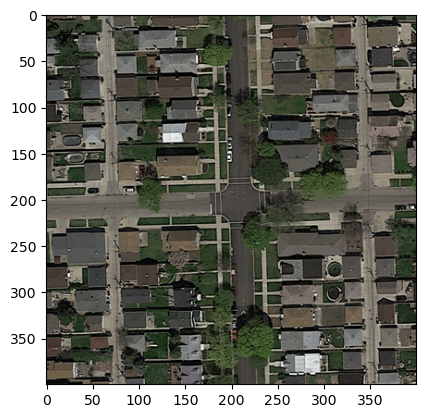

In [ ]:
# show first sample
plt.imshow(x_train[0]);

Tuning hyperparameters :
training different combinations of hyperparameters to find the best model ( epochs = 100)

  - ```input_side```: size of the image for the input to the model : 64, 128

  - ```num_blocks```: number of blocks in both encoder and decorder part : 3 , 4, 5 - for 64 input_size and 4, 5, 6 for 128 input_size

In [ ]:
# default hyperpameters, using Adam optimizer
params = {}
params['image_side'] = IMAGE_SIDE
params['activation_'] = 'elu'
params['regularizer_'] = None
params['starting_num_channels'] = 16
params['metrics'] = [F1_score]
params['metrics_names'] = ['loss', 'F1_score']
params['batch_size'] = 16
params['reg_name'] = None
params['lambd'] = 0
params['loss'] = soft_dice_loss
params['main_metric_fn'] = F1_score

In [ ]:
input_sides = [256]
blocks = [6]
dropouts = [0]
rot_angles = [45]
batch_sizes = [16]
bpes = [400]
epochs = 1000
models = dict()

it = len(input_sides) * len(blocks) * len(dropouts) * len(rot_angles) * len(batch_sizes) * len(bpes)
eps = it * epochs
t = (22 * eps) / 3600 
print(f'Training for {eps} epochs in total. Around {t} hours.')

st = time.time()
for input_side in input_sides:
    for block in blocks:
        for dropout in dropouts:
            for rot_angle in rot_angles:
                for batch_size in batch_sizes:
                    for bpe in bpes:
                        params['batch_size'] = batch_size
                        params['starting_num_channels'] = batch_size
                        params['input_side'] = input_side
                        params['num_blocks'] = block
                        params['optimizer'] = tf.keras.optimizers.Adam()
                        params['dropout'] = dropout
                        params['batches_per_epoch'] = bpe
                        m_name = 'sd_' + str(input_side) + "_" + str(bpe) + "_" + str(dropout)
                        print(m_name)
                        params['path'] = '/saved_models/' + m_name
                        models[m_name] = ModelWrapper(Unet(params), params)
                        models[m_name].train(x_train, y_train, x_test=x_test, y_test=y_test, epochs=epochs, rot_angle=rot_angle)
                        models[m_name].save_model()
                        models[m_name].load_model()
et = time.time()
rt = (et - st) / 3600
print(f'Took {rt} hours to complete.')

Training for 1000 epochs in total. Around 6.111111111111111 hours.
sd_256_400_0
1/1 [==============================] - 0s 20ms/step
Epoch: 0001: loss_train: 0.28600, F1_score_train: 0.71651, loss_test: 0.39581, F1_score_test: 0.60428, Full_img_F1_score: 0.59078, 
1/1 [==============================] - 0s 20ms/step
Epoch: 0002: loss_train: 0.18116, F1_score_train: 0.81902, loss_test: 0.24671, F1_score_test: 0.75369, Full_img_F1_score: 0.74754, 
1/1 [==============================] - 0s 20ms/step
Epoch: 0003: loss_train: 0.14965, F1_score_train: 0.85045, loss_test: 0.34730, F1_score_test: 0.65278, Full_img_F1_score: 0.61709, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0004: loss_train: 0.13262, F1_score_train: 0.86745, loss_test: 0.22185, F1_score_test: 0.77878, Full_img_F1_score: 0.74869, 
1/1 [==============================] - 0s 20ms/step
Epoch: 0005: loss_train: 0.12915, F1_score_train: 0.87091, loss_test: 0.45355, F1_score_test: 0.54652, Full_img_F1_score: 0.48656, 


1/1 [==============================] - 0s 22ms/step
Epoch: 0025: loss_train: 0.05047, F1_score_train: 0.94955, loss_test: 0.15603, F1_score_test: 0.84397, Full_img_F1_score: 0.81412, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0026: loss_train: 0.04889, F1_score_train: 0.95113, loss_test: 0.14809, F1_score_test: 0.85192, Full_img_F1_score: 0.82663, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0027: loss_train: 0.04852, F1_score_train: 0.95150, loss_test: 0.15055, F1_score_test: 0.84946, Full_img_F1_score: 0.77772, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0028: loss_train: 0.05878, F1_score_train: 0.94123, loss_test: 0.14443, F1_score_test: 0.85560, Full_img_F1_score: 0.80100, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0029: loss_train: 0.04695, F1_score_train: 0.95307, loss_test: 0.19149, F1_score_test: 0.80853, Full_img_F1_score: 0.77384, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0030: loss_train: 0.0

1/1 [==============================] - 0s 22ms/step
Epoch: 0073: loss_train: 0.02700, F1_score_train: 0.97301, loss_test: 0.13104, F1_score_test: 0.86900, Full_img_F1_score: 0.83314, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0074: loss_train: 0.02699, F1_score_train: 0.97302, loss_test: 0.16513, F1_score_test: 0.83487, Full_img_F1_score: 0.81791, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0075: loss_train: 0.02620, F1_score_train: 0.97381, loss_test: 0.14242, F1_score_test: 0.85761, Full_img_F1_score: 0.82097, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0076: loss_train: 0.02806, F1_score_train: 0.97195, loss_test: 0.15414, F1_score_test: 0.84583, Full_img_F1_score: 0.80956, 
1/1 [==============================] - 0s 25ms/step
Epoch: 0077: loss_train: 0.02634, F1_score_train: 0.97367, loss_test: 0.13347, F1_score_test: 0.86655, Full_img_F1_score: 0.81972, 
1/1 [==============================] - 0s 24ms/step
Epoch: 0078: loss_train: 0.0

1/1 [==============================] - 0s 22ms/step
Epoch: 0121: loss_train: 0.02167, F1_score_train: 0.97834, loss_test: 0.14221, F1_score_test: 0.85781, Full_img_F1_score: 0.82718, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0122: loss_train: 0.02133, F1_score_train: 0.97868, loss_test: 0.14165, F1_score_test: 0.85836, Full_img_F1_score: 0.81836, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0123: loss_train: 0.02105, F1_score_train: 0.97896, loss_test: 0.12776, F1_score_test: 0.87222, Full_img_F1_score: 0.81994, 
1/1 [==============================] - 0s 24ms/step
Epoch: 0124: loss_train: 0.02099, F1_score_train: 0.97903, loss_test: 0.12408, F1_score_test: 0.87592, Full_img_F1_score: 0.82413, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0125: loss_train: 0.02136, F1_score_train: 0.97865, loss_test: 0.13635, F1_score_test: 0.86365, Full_img_F1_score: 0.82986, 
1/1 [==============================] - 0s 25ms/step
Epoch: 0126: loss_train: 0.0

1/1 [==============================] - 0s 23ms/step
Epoch: 0169: loss_train: 0.01868, F1_score_train: 0.98133, loss_test: 0.14387, F1_score_test: 0.85610, Full_img_F1_score: 0.82164, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0170: loss_train: 0.01873, F1_score_train: 0.98127, loss_test: 0.13632, F1_score_test: 0.86369, Full_img_F1_score: 0.82276, 
1/1 [==============================] - 0s 25ms/step
Epoch: 0171: loss_train: 0.01875, F1_score_train: 0.98125, loss_test: 0.14458, F1_score_test: 0.85544, Full_img_F1_score: 0.81786, 
1/1 [==============================] - 0s 24ms/step
Epoch: 0172: loss_train: 0.01841, F1_score_train: 0.98160, loss_test: 0.14832, F1_score_test: 0.85167, Full_img_F1_score: 0.81998, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0173: loss_train: 0.01834, F1_score_train: 0.98167, loss_test: 0.17317, F1_score_test: 0.82684, Full_img_F1_score: 0.74985, 
1/1 [==============================] - 0s 24ms/step
Epoch: 0174: loss_train: 0.0

1/1 [==============================] - 0s 25ms/step
Epoch: 0217: loss_train: 0.01675, F1_score_train: 0.98325, loss_test: 0.14782, F1_score_test: 0.85218, Full_img_F1_score: 0.82827, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0218: loss_train: 0.01673, F1_score_train: 0.98327, loss_test: 0.13115, F1_score_test: 0.86883, Full_img_F1_score: 0.83514, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0219: loss_train: 0.01666, F1_score_train: 0.98334, loss_test: 0.18760, F1_score_test: 0.81238, Full_img_F1_score: 0.78031, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0220: loss_train: 0.01662, F1_score_train: 0.98339, loss_test: 0.13030, F1_score_test: 0.86971, Full_img_F1_score: 0.82775, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0221: loss_train: 0.01683, F1_score_train: 0.98318, loss_test: 0.12802, F1_score_test: 0.87199, Full_img_F1_score: 0.81186, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0222: loss_train: 0.0

1/1 [==============================] - 0s 23ms/step
Epoch: 0265: loss_train: 0.01578, F1_score_train: 0.98422, loss_test: 0.13285, F1_score_test: 0.86713, Full_img_F1_score: 0.80414, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0266: loss_train: 0.01543, F1_score_train: 0.98458, loss_test: 0.14283, F1_score_test: 0.85717, Full_img_F1_score: 0.81198, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0267: loss_train: 0.01555, F1_score_train: 0.98446, loss_test: 0.14428, F1_score_test: 0.85573, Full_img_F1_score: 0.80629, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0268: loss_train: 0.01535, F1_score_train: 0.98465, loss_test: 0.12130, F1_score_test: 0.87868, Full_img_F1_score: 0.82857, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0269: loss_train: 0.01740, F1_score_train: 0.98261, loss_test: 0.14639, F1_score_test: 0.85363, Full_img_F1_score: 0.81568, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0270: loss_train: 0.0

1/1 [==============================] - 0s 23ms/step
Epoch: 0313: loss_train: 0.01475, F1_score_train: 0.98526, loss_test: 0.12364, F1_score_test: 0.87636, Full_img_F1_score: 0.81276, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0314: loss_train: 0.01484, F1_score_train: 0.98517, loss_test: 0.13080, F1_score_test: 0.86919, Full_img_F1_score: 0.82273, 
1/1 [==============================] - 0s 24ms/step
Epoch: 0315: loss_train: 0.01435, F1_score_train: 0.98566, loss_test: 0.11683, F1_score_test: 0.88316, Full_img_F1_score: 0.82961, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0316: loss_train: 0.01433, F1_score_train: 0.98568, loss_test: 0.12419, F1_score_test: 0.87581, Full_img_F1_score: 0.83801, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0317: loss_train: 0.01430, F1_score_train: 0.98570, loss_test: 0.12109, F1_score_test: 0.87892, Full_img_F1_score: 0.83273, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0318: loss_train: 0.0

1/1 [==============================] - 0s 23ms/step
Epoch: 0361: loss_train: 0.01386, F1_score_train: 0.98615, loss_test: 0.14566, F1_score_test: 0.85433, Full_img_F1_score: 0.80809, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0362: loss_train: 0.01398, F1_score_train: 0.98603, loss_test: 0.12630, F1_score_test: 0.87369, Full_img_F1_score: 0.82345, 
1/1 [==============================] - 0s 24ms/step
Epoch: 0363: loss_train: 0.01368, F1_score_train: 0.98633, loss_test: 0.11989, F1_score_test: 0.88011, Full_img_F1_score: 0.81864, 
1/1 [==============================] - 0s 24ms/step
Epoch: 0364: loss_train: 0.01401, F1_score_train: 0.98599, loss_test: 0.13020, F1_score_test: 0.86980, Full_img_F1_score: 0.82485, 
1/1 [==============================] - 0s 24ms/step
Epoch: 0365: loss_train: 0.01375, F1_score_train: 0.98625, loss_test: 0.12896, F1_score_test: 0.87105, Full_img_F1_score: 0.82982, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0366: loss_train: 0.0

1/1 [==============================] - 0s 22ms/step
Epoch: 0409: loss_train: 0.01335, F1_score_train: 0.98666, loss_test: 0.14493, F1_score_test: 0.85507, Full_img_F1_score: 0.80569, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0410: loss_train: 0.01335, F1_score_train: 0.98666, loss_test: 0.12438, F1_score_test: 0.87563, Full_img_F1_score: 0.82802, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0411: loss_train: 0.01321, F1_score_train: 0.98680, loss_test: 0.13497, F1_score_test: 0.86503, Full_img_F1_score: 0.82987, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0412: loss_train: 0.01322, F1_score_train: 0.98679, loss_test: 0.13056, F1_score_test: 0.86944, Full_img_F1_score: 0.81877, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0413: loss_train: 0.01316, F1_score_train: 0.98684, loss_test: 0.13447, F1_score_test: 0.86553, Full_img_F1_score: 0.82980, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0414: loss_train: 0.0

1/1 [==============================] - 0s 23ms/step
Epoch: 0457: loss_train: 0.01278, F1_score_train: 0.98722, loss_test: 0.12418, F1_score_test: 0.87583, Full_img_F1_score: 0.81913, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0458: loss_train: 0.01240, F1_score_train: 0.98760, loss_test: 0.12132, F1_score_test: 0.87869, Full_img_F1_score: 0.81468, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0459: loss_train: 0.01265, F1_score_train: 0.98735, loss_test: 0.12277, F1_score_test: 0.87722, Full_img_F1_score: 0.82152, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0460: loss_train: 0.01272, F1_score_train: 0.98729, loss_test: 0.12836, F1_score_test: 0.87163, Full_img_F1_score: 0.82624, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0461: loss_train: 0.01247, F1_score_train: 0.98754, loss_test: 0.13701, F1_score_test: 0.86298, Full_img_F1_score: 0.82784, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0462: loss_train: 0.0

1/1 [==============================] - 0s 24ms/step
Epoch: 0505: loss_train: 0.01168, F1_score_train: 0.98832, loss_test: 0.13019, F1_score_test: 0.86981, Full_img_F1_score: 0.82316, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0506: loss_train: 0.01159, F1_score_train: 0.98841, loss_test: 0.13200, F1_score_test: 0.86799, Full_img_F1_score: 0.82233, 
1/1 [==============================] - 0s 25ms/step
Epoch: 0507: loss_train: 0.01146, F1_score_train: 0.98855, loss_test: 0.13295, F1_score_test: 0.86704, Full_img_F1_score: 0.82829, 
1/1 [==============================] - 0s 25ms/step
Epoch: 0508: loss_train: 0.01151, F1_score_train: 0.98849, loss_test: 0.12942, F1_score_test: 0.87059, Full_img_F1_score: 0.81554, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0509: loss_train: 0.01153, F1_score_train: 0.98847, loss_test: 0.13845, F1_score_test: 0.86156, Full_img_F1_score: 0.82285, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0510: loss_train: 0.0

1/1 [==============================] - 0s 23ms/step
Epoch: 0553: loss_train: 0.01111, F1_score_train: 0.98889, loss_test: 0.13590, F1_score_test: 0.86411, Full_img_F1_score: 0.81184, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0554: loss_train: 0.01110, F1_score_train: 0.98891, loss_test: 0.12606, F1_score_test: 0.87391, Full_img_F1_score: 0.82719, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0555: loss_train: 0.01113, F1_score_train: 0.98888, loss_test: 0.12804, F1_score_test: 0.87199, Full_img_F1_score: 0.82934, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0556: loss_train: 0.01107, F1_score_train: 0.98893, loss_test: 0.12429, F1_score_test: 0.87571, Full_img_F1_score: 0.82960, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0557: loss_train: 0.01099, F1_score_train: 0.98901, loss_test: 0.13190, F1_score_test: 0.86809, Full_img_F1_score: 0.82736, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0558: loss_train: 0.0

1/1 [==============================] - 0s 21ms/step
Epoch: 0601: loss_train: 0.01056, F1_score_train: 0.98944, loss_test: 0.13352, F1_score_test: 0.86648, Full_img_F1_score: 0.82101, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0602: loss_train: 0.01072, F1_score_train: 0.98928, loss_test: 0.13621, F1_score_test: 0.86380, Full_img_F1_score: 0.79522, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0603: loss_train: 0.01078, F1_score_train: 0.98923, loss_test: 0.13386, F1_score_test: 0.86613, Full_img_F1_score: 0.82305, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0604: loss_train: 0.01067, F1_score_train: 0.98933, loss_test: 0.14288, F1_score_test: 0.85713, Full_img_F1_score: 0.80930, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0605: loss_train: 0.01047, F1_score_train: 0.98953, loss_test: 0.12700, F1_score_test: 0.87300, Full_img_F1_score: 0.82347, 
1/1 [==============================] - 0s 23ms/step
Epoch: 0606: loss_train: 0.0

1/1 [==============================] - 0s 21ms/step
Epoch: 0649: loss_train: 0.01031, F1_score_train: 0.98970, loss_test: 0.13751, F1_score_test: 0.86249, Full_img_F1_score: 0.81537, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0650: loss_train: 0.01025, F1_score_train: 0.98976, loss_test: 0.13157, F1_score_test: 0.86843, Full_img_F1_score: 0.82249, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0651: loss_train: 0.01022, F1_score_train: 0.98979, loss_test: 0.14098, F1_score_test: 0.85901, Full_img_F1_score: 0.80625, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0652: loss_train: 0.01030, F1_score_train: 0.98971, loss_test: 0.12977, F1_score_test: 0.87021, Full_img_F1_score: 0.82462, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0653: loss_train: 0.01014, F1_score_train: 0.98986, loss_test: 0.13674, F1_score_test: 0.86327, Full_img_F1_score: 0.82189, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0654: loss_train: 0.0

1/1 [==============================] - 0s 21ms/step
Epoch: 0697: loss_train: 0.01003, F1_score_train: 0.98997, loss_test: 0.12836, F1_score_test: 0.87165, Full_img_F1_score: 0.82629, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0698: loss_train: 0.00991, F1_score_train: 0.99009, loss_test: 0.13340, F1_score_test: 0.86661, Full_img_F1_score: 0.80234, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0699: loss_train: 0.00993, F1_score_train: 0.99008, loss_test: 0.13084, F1_score_test: 0.86917, Full_img_F1_score: 0.82360, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0700: loss_train: 0.00990, F1_score_train: 0.99010, loss_test: 0.13040, F1_score_test: 0.86960, Full_img_F1_score: 0.80203, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0701: loss_train: 0.00990, F1_score_train: 0.99011, loss_test: 0.14256, F1_score_test: 0.85742, Full_img_F1_score: 0.82336, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0702: loss_train: 0.0

1/1 [==============================] - 0s 21ms/step
Epoch: 0745: loss_train: 0.00960, F1_score_train: 0.99040, loss_test: 0.12702, F1_score_test: 0.87298, Full_img_F1_score: 0.83028, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0746: loss_train: 0.00969, F1_score_train: 0.99031, loss_test: 0.11809, F1_score_test: 0.88190, Full_img_F1_score: 0.83231, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0747: loss_train: 0.00963, F1_score_train: 0.99038, loss_test: 0.13089, F1_score_test: 0.86912, Full_img_F1_score: 0.82729, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0748: loss_train: 0.00976, F1_score_train: 0.99024, loss_test: 0.12581, F1_score_test: 0.87420, Full_img_F1_score: 0.82384, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0749: loss_train: 0.00964, F1_score_train: 0.99037, loss_test: 0.11806, F1_score_test: 0.88196, Full_img_F1_score: 0.81639, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0750: loss_train: 0.0

1/1 [==============================] - 0s 21ms/step
Epoch: 0793: loss_train: 0.00951, F1_score_train: 0.99050, loss_test: 0.12891, F1_score_test: 0.87107, Full_img_F1_score: 0.81839, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0794: loss_train: 0.00947, F1_score_train: 0.99053, loss_test: 0.14008, F1_score_test: 0.85989, Full_img_F1_score: 0.82593, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0795: loss_train: 0.00954, F1_score_train: 0.99046, loss_test: 0.14121, F1_score_test: 0.85880, Full_img_F1_score: 0.82544, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0796: loss_train: 0.00943, F1_score_train: 0.99057, loss_test: 0.13298, F1_score_test: 0.86701, Full_img_F1_score: 0.81911, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0797: loss_train: 0.00948, F1_score_train: 0.99053, loss_test: 0.13329, F1_score_test: 0.86672, Full_img_F1_score: 0.81942, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0798: loss_train: 0.0

1/1 [==============================] - 0s 21ms/step
Epoch: 0841: loss_train: 0.00928, F1_score_train: 0.99072, loss_test: 0.12231, F1_score_test: 0.87769, Full_img_F1_score: 0.81818, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0842: loss_train: 0.00925, F1_score_train: 0.99075, loss_test: 0.13127, F1_score_test: 0.86873, Full_img_F1_score: 0.82465, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0843: loss_train: 0.00914, F1_score_train: 0.99086, loss_test: 0.13144, F1_score_test: 0.86857, Full_img_F1_score: 0.82152, 
1/1 [==============================] - 0s 20ms/step
Epoch: 0844: loss_train: 0.00904, F1_score_train: 0.99096, loss_test: 0.13015, F1_score_test: 0.86985, Full_img_F1_score: 0.82373, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0845: loss_train: 0.00931, F1_score_train: 0.99070, loss_test: 0.13544, F1_score_test: 0.86457, Full_img_F1_score: 0.82291, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0846: loss_train: 0.0

1/1 [==============================] - 0s 21ms/step
Epoch: 0889: loss_train: 0.00902, F1_score_train: 0.99098, loss_test: 0.12984, F1_score_test: 0.87016, Full_img_F1_score: 0.82055, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0890: loss_train: 0.00900, F1_score_train: 0.99100, loss_test: 0.13878, F1_score_test: 0.86121, Full_img_F1_score: 0.82777, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0891: loss_train: 0.00914, F1_score_train: 0.99086, loss_test: 0.13744, F1_score_test: 0.86257, Full_img_F1_score: 0.81903, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0892: loss_train: 0.00904, F1_score_train: 0.99097, loss_test: 0.12916, F1_score_test: 0.87085, Full_img_F1_score: 0.82721, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0893: loss_train: 0.00888, F1_score_train: 0.99112, loss_test: 0.12809, F1_score_test: 0.87190, Full_img_F1_score: 0.81474, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0894: loss_train: 0.0

1/1 [==============================] - 0s 21ms/step
Epoch: 0937: loss_train: 0.00876, F1_score_train: 0.99125, loss_test: 0.11652, F1_score_test: 0.88348, Full_img_F1_score: 0.82132, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0938: loss_train: 0.00876, F1_score_train: 0.99124, loss_test: 0.12638, F1_score_test: 0.87362, Full_img_F1_score: 0.81741, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0939: loss_train: 0.00883, F1_score_train: 0.99118, loss_test: 0.12114, F1_score_test: 0.87886, Full_img_F1_score: 0.82068, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0940: loss_train: 0.00888, F1_score_train: 0.99112, loss_test: 0.13101, F1_score_test: 0.86899, Full_img_F1_score: 0.82197, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0941: loss_train: 0.00886, F1_score_train: 0.99114, loss_test: 0.12616, F1_score_test: 0.87384, Full_img_F1_score: 0.81898, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0942: loss_train: 0.0

1/1 [==============================] - 0s 22ms/step
Epoch: 0985: loss_train: 0.00887, F1_score_train: 0.99113, loss_test: 0.13478, F1_score_test: 0.86525, Full_img_F1_score: 0.81887, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0986: loss_train: 0.00874, F1_score_train: 0.99127, loss_test: 0.13287, F1_score_test: 0.86714, Full_img_F1_score: 0.81740, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0987: loss_train: 0.00874, F1_score_train: 0.99126, loss_test: 0.13051, F1_score_test: 0.86949, Full_img_F1_score: 0.81716, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0988: loss_train: 0.00867, F1_score_train: 0.99133, loss_test: 0.12965, F1_score_test: 0.87032, Full_img_F1_score: 0.81974, 
1/1 [==============================] - 0s 21ms/step
Epoch: 0989: loss_train: 0.00865, F1_score_train: 0.99135, loss_test: 0.12623, F1_score_test: 0.87379, Full_img_F1_score: 0.81903, 
1/1 [==============================] - 0s 22ms/step
Epoch: 0990: loss_train: 0.0

1 hyperparameters permutations.


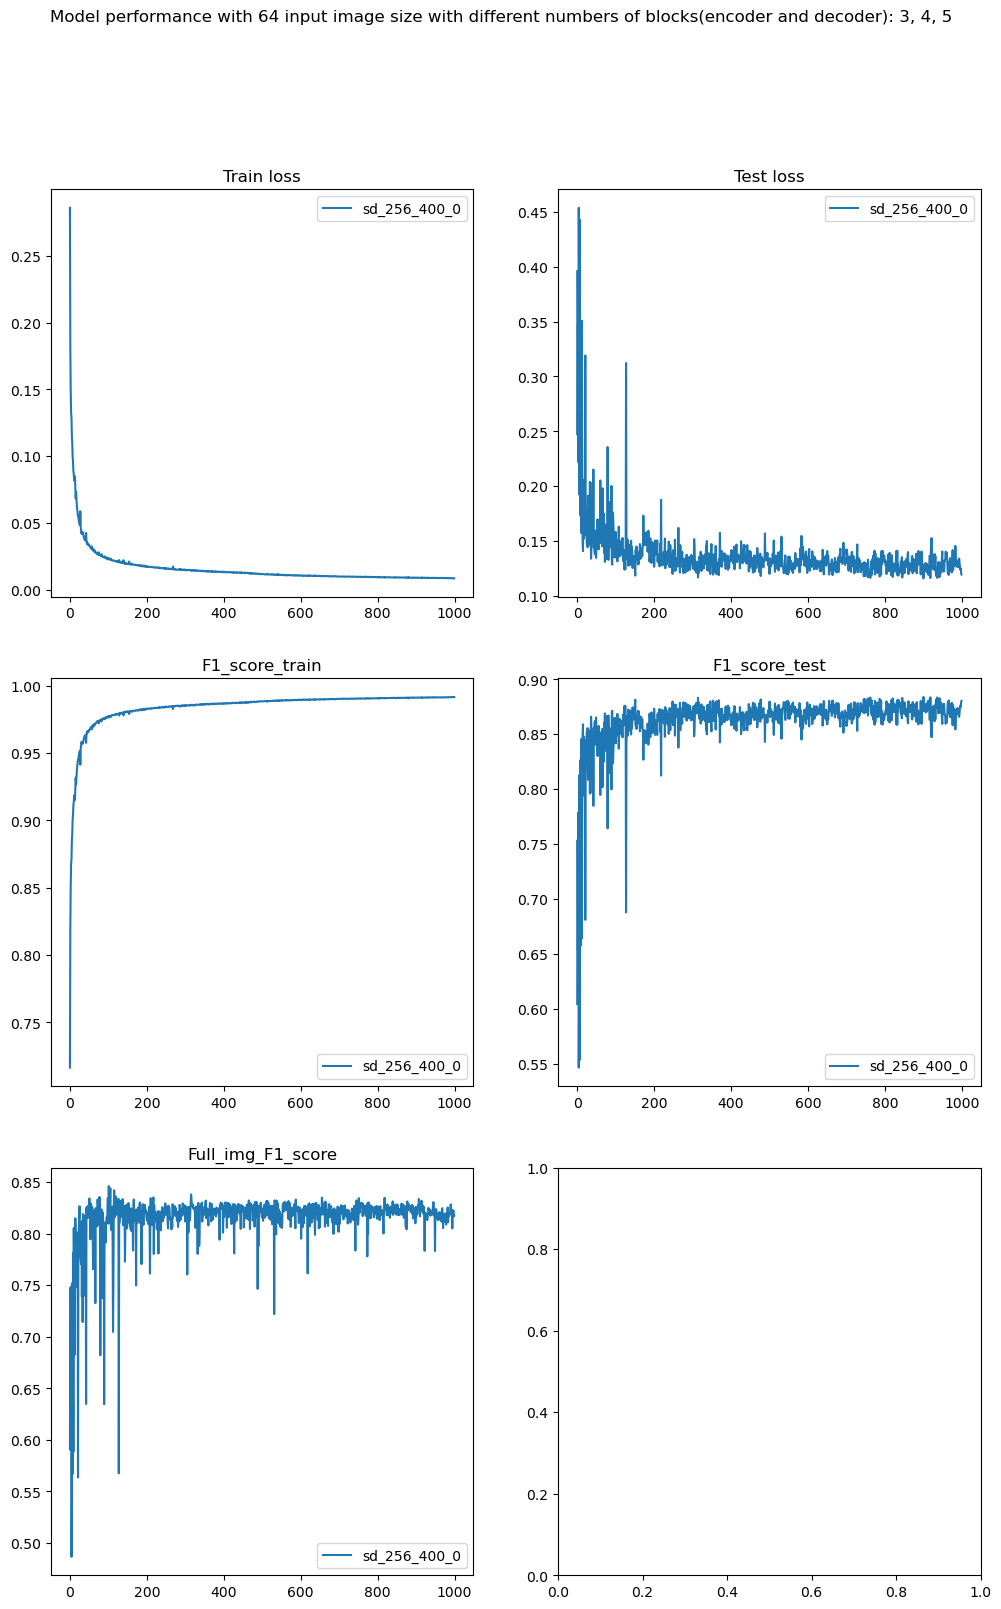

In [ ]:
hp_configs = it
cols = 3
rows = (hp_configs // cols) + 1
print(f'{hp_configs} hyperparameters permutations.')

# visuzalization model performance with 64 input_side with different num_blocks : 3, 4, 5
fig, ax = plt.subplots(3, 2, figsize=(12, 18))
plt.suptitle(
    'Model performance with 64 input image size with different numbers of blocks(encoder and decoder): 3, 4, 5'
)

for k, m in models.items():
    ax[0,0].plot(m.metrics_per_epoch['loss_train'], label=k)
ax[0,0].set_title('Train loss')
ax[0,0].legend()

for k, m in models.items():
    ax[0,1].plot(m.metrics_per_epoch['loss_test'], label=k)
ax[0,1].set_title('Test loss')
ax[0,1].legend()

for k, m in models.items():
    ax[1,0].plot(m.metrics_per_epoch['F1_score_train'], label=k)
ax[1,0].set_title('F1_score_train')
ax[1,0].legend()

for k, m in models.items():
    ax[1,1].plot(m.metrics_per_epoch['F1_score_test'], label=k)
ax[1,1].set_title('F1_score_test')
ax[1,1].legend()

for k, m in models.items():
    ax[2,0].plot(m.metrics_per_epoch['Full_img_F1_score'], label=k)
ax[2,0].set_title('Full_img_F1_score')
ax[2,0].legend()

plt.show()

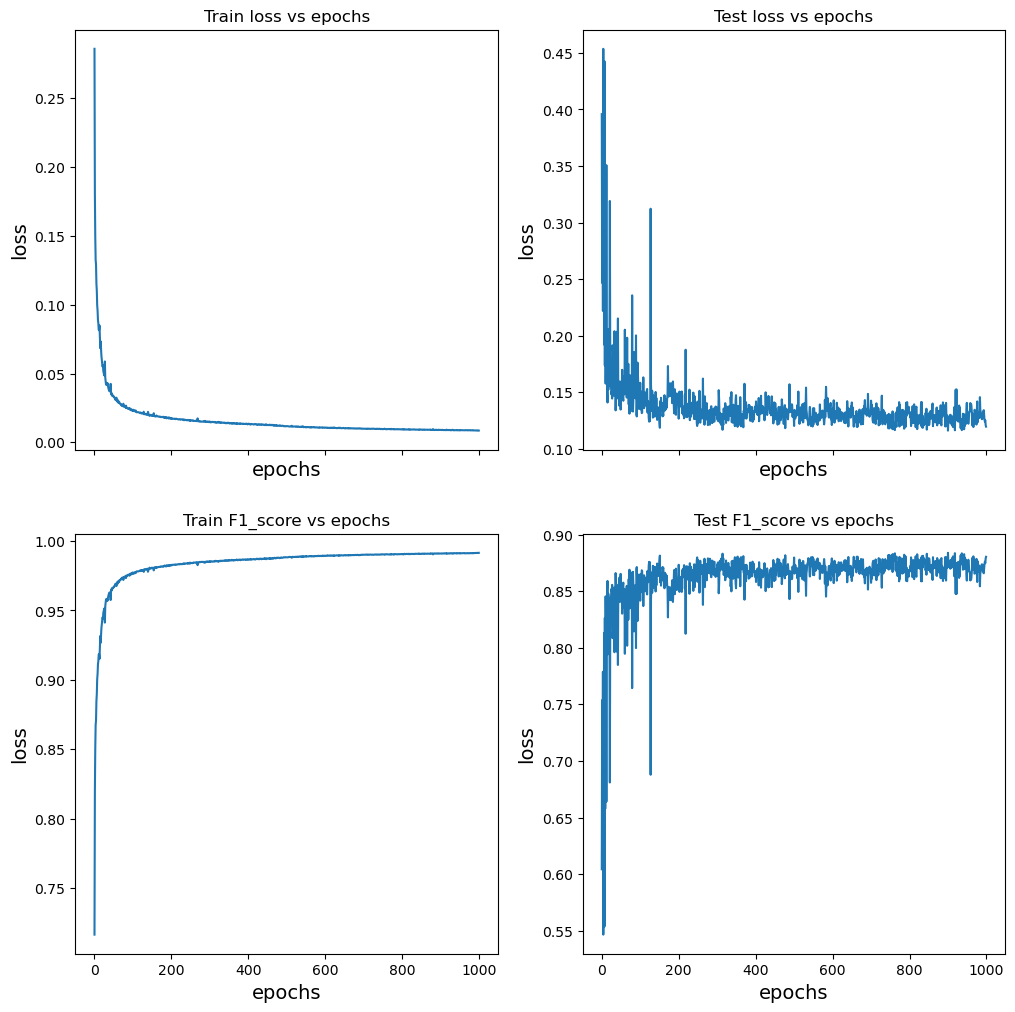

In [ ]:
final_model = 0
for model in models.values():
    final_model = model
    
final_model.draw_metrics()
final_model.model.save('final_model.h5')

In [ ]:
preds = final_model.predict(test_data, shift=8)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2022-12-22 14:20:17.636857: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f1fdc528f00 of size 256 next 670011
2022-12-22 14:20:17.636860: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f1fdc529000 of size 256 next 670125
2022-12-22 14:20:17.636862: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f1fdc529100 of size 256 next 669931
2022-12-22 14:20:17.636864: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f1fdc529200 of size 256 next 670063
2022-12-22 14:20:17.636866: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f1fdc529300 of size 256 next 670115
2022-12-22 14:20:17.636868: I tensorflow/tsl/framewo

ResourceExhaustedError: Graph execution error:

Detected at node 'model_8/conv2d_transpose_4/conv2d_transpose' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/usr/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/lib/python3.10/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/usr/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1899, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/usr/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/usr/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 530, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/usr/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_895183/181326669.py", line 33, in <module>
      models[m_name].train(x_train, y_train, x_test=x_test, y_test=y_test, epochs=epochs, rot_angle=rot_angle)
    File "/tmp/ipykernel_895183/1691889209.py", line 117, in train
      self.metrics_per_epoch[self.main_metric_name].append(self.evaluate(x_test, y_test, shift))
    File "/tmp/ipykernel_895183/1691889209.py", line 156, in evaluate
      y_pred = self.predict(images, shift)
    File "/tmp/ipykernel_895183/1691889209.py", line 148, in predict
      pred[:, x:x+self.input_side, y:y+self.input_side, :] += self.model.predict(images[:, x:x+self.input_side, y:y+self.input_side, :])
    File "/usr/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/lib/python3.10/site-packages/keras/engine/training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/usr/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "/usr/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "/usr/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
      return self(x, training=False)
    File "/usr/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/lib/python3.10/site-packages/keras/layers/convolutional/conv2d_transpose.py", line 296, in call
      outputs = backend.conv2d_transpose(
    File "/usr/lib/python3.10/site-packages/keras/backend.py", line 6122, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(
Node: 'model_8/conv2d_transpose_4/conv2d_transpose'
OOM when allocating tensor with shape[32,16,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_8/conv2d_transpose_4/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_11055703]

In [ ]:
from mask_to_submission import *

# FILE_PATH = path=r'/content/gdrive/MyDrive'
def save_preds(preds):
    pred_path = FILE_PATH + '/predictions'
    pred_img_names = [pred_path + f'/pred_{i + 1}.png' for i in range(len(preds))]
    for i in range(len(preds)):
        img = Image.fromarray((preds[i,:,:,0] * 255.).astype(np.uint8))
        img.save(pred_img_names[i])
    masks_to_submission(FILE_PATH + "/submission.csv", *pred_img_names) 

In [ ]:
save_preds(preds)

./data/predictions/pred_1.png
./data/predictions/pred_2.png
./data/predictions/pred_3.png
./data/predictions/pred_4.png
./data/predictions/pred_5.png
./data/predictions/pred_6.png
./data/predictions/pred_7.png
./data/predictions/pred_8.png
./data/predictions/pred_9.png
./data/predictions/pred_10.png
./data/predictions/pred_11.png
./data/predictions/pred_12.png
./data/predictions/pred_13.png
./data/predictions/pred_14.png
./data/predictions/pred_15.png
./data/predictions/pred_16.png
./data/predictions/pred_17.png
./data/predictions/pred_18.png
./data/predictions/pred_19.png
./data/predictions/pred_20.png
./data/predictions/pred_21.png
./data/predictions/pred_22.png
./data/predictions/pred_23.png
./data/predictions/pred_24.png
./data/predictions/pred_25.png
./data/predictions/pred_26.png
./data/predictions/pred_27.png
./data/predictions/pred_28.png
./data/predictions/pred_29.png
./data/predictions/pred_30.png
./data/predictions/pred_31.png
./data/predictions/pred_32.png
./data/prediction